In [20]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import pandas as pd
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, FixedLocator
from matplotlib.patches import Rectangle

In [21]:
# Set up PPF scale for CDF plots
class PPFScale(mscale.ScaleBase):
    name = "ppf"

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis)

    def get_transform(self):
        return self.PPFTransform()

    def set_default_locators_and_formatters(self, axis):
        class VarFormatter(Formatter):
            def __call__(self, x, pos=None):
                return f"{x}"[1:]

        axis.set_major_locator(FixedLocator(np.array([0,.0001,.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,.999,.9999,1])))
        axis.set_major_formatter(VarFormatter())


    def limit_range_for_scale(self, vmin, vmax, minpos):
        return max(vmin, 1e-6), min(vmax, 1-1e-6)

    class PPFTransform(mtransforms.Transform):
        input_dims = output_dims = 1

        def ___init__(self, thresh):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            return stats.norm.ppf(a)

        def inverted(self):
            return PPFScale.IPPFTransform()

    class IPPFTransform(mtransforms.Transform):
        input_dims = output_dims = 1

        def transform_non_affine(self, a):
            return stats.norm.cdf(a)

        def inverted(self):
            return PPFScale.PPFTransform()

# Register PPF scale
mscale.register_scale(PPFScale)

# Set up fonts
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.size"] = 12

/tmp/ipykernel_1160494/1452132680.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  formdata = pd.read_csv("../data/form.5mhz.188cell.csv", names=names, index_col=False)


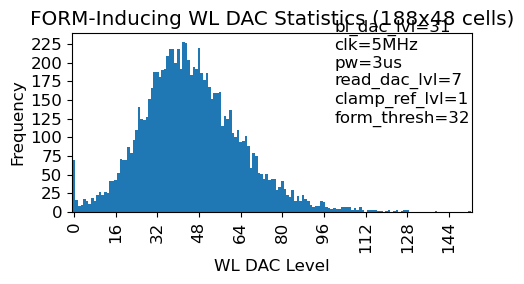

In [22]:
# Load log file
names = ["chip", "time", "addr", "operation", "mask", "wl_dac_lvl", "bsl_dac_lvl", "sa_do"]
formdata = pd.read_csv("../data/form.5mhz.188cell.csv", names=names, index_col=False)
formdata.sa_do = formdata.sa_do.shift(-1, fill_value=0)
formdata["nform"] = formdata.sa_do.apply(lambda di: bin(di).count("1"))
formdata = formdata[formdata.operation == "SET"]

# Figure
plt.figure(figsize=(5,3))
formdata[formdata.operation == "SET"].groupby("wl_dac_lvl").sum()["nform"].plot.bar(width=1)
plt.title("FORM-Inducing WL DAC Statistics (188x48 cells)")
plt.xlabel("WL DAC Level")
plt.ylabel("Frequency")
plt.text(100, 120, "bl_dac_lvl=31\nclk=5MHz\npw=3us\nread_dac_lvl=7\nclamp_ref_lvl=1\nform_thresh=32")
plt.locator_params(nbins=10)
plt.tight_layout()
plt.savefig("figs/form.wl.stats.pdf")

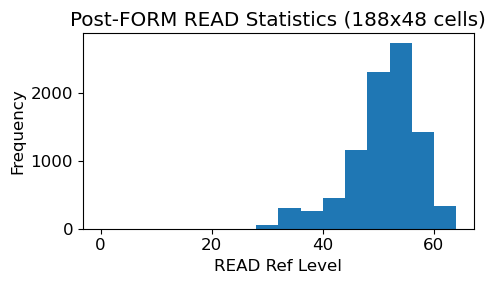

In [23]:
# Load log file
names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
formreaddata = pd.read_csv("../data/formread.5mhz.188cell.csv", names=names, index_col=False, delimiter="\t")

# Figure
plt.figure(figsize=(5,3))
plt.bar(np.arange(2, 64, 4), np.bincount(formreaddata[formreaddata.columns[-48:]].values.flatten()), width=4)
plt.title("Post-FORM READ Statistics (188x48 cells)")
plt.xlabel("READ Ref Level")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figs/form.read.stats.pdf")

[[1152    0]
 [   0 1152]]
[[575   1   0   0]
 [  1 575   0   0]
 [  0   1 575   0]
 [  0   0   0 576]]
[[287   1   0   0   0   0   0   0]
 [  2 267  19   0   0   0   0   0]
 [  0  31 244  13   0   0   0   0]
 [  0   1  47 231   9   0   0   0]
 [  0   2  33  67 184   2   0   0]
 [  0   0   7  10  15 254   2   0]
 [  0   0   0   0   0   2 286   0]
 [  0   0   0   0   0   0   0 288]]
[[  2   0   0   0   0   0   0   0   0   0   0   0   0   0  15 127]
 [  2 107  33   1   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0  13 105  25   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1  33  81  27   2   0   0   0   0   0   0   0   0   0   0]
 [  0   0   8  58  60  14   4   0   0   0   0   0   0   0   0   0]
 [  0   0   1  15  55  67   5   1   0   0   0   0   0   0   0   0]
 [  0   0   0   3  24  57  42  17   1   0   0   0   0   0   0   0]
 [  0   0   0   5  15  42  47  26   9   0   0   0   0   0   0   0]
 [  0   0   0   3  14  29  45  32  14   6   1   0   0   0   0   0]
 [  0   0   

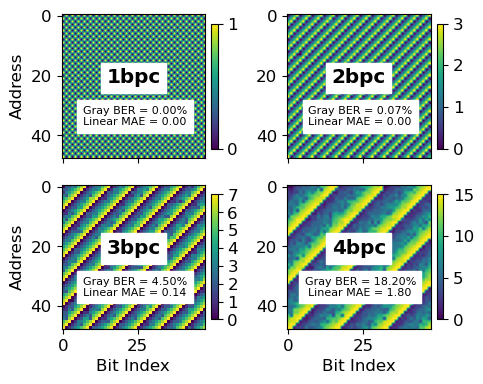

In [24]:
# Produce checkerboard plots for 1-4 bpc
confmats = []
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(5,4))
for bpc in range(1, 5):
  # Subplot
  plt.subplot(220 + bpc)

  # Load data
  names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
  data = pd.read_csv(f"../data/{'cb' if bpc==4 else ''}{bpc}bpc.csv", sep="\t", names=names)

  # Show multi-bit result
  matdata = data[data.columns[-48:]].values[:48]
  im = plt.imshow(matdata, vmin=0, vmax=2**bpc-1)
  cbar = plt.colorbar(im, fraction=0.04, pad=0.04)
  if bpc != 4:
    cbar.set_ticks(range(2**bpc))
  # cbar.set_label("READ Value")
  plt.title(f"{bpc}bpc", x=0.5, y=0.5, verticalalignment="center", horizontalalignment="center", backgroundcolor="white", fontweight="bold")
  if bpc > 2:
    plt.xlabel("Bit Index")
  if bpc % 2 == 1:
    plt.ylabel("Address")

  # Load data into confmat
  confmat = np.zeros(shape=(2**bpc, 2**bpc))
  for i in range(48):
    for j in range(48):
      confmat[(data["addr"][i] + j) % (2**bpc)][matdata[i][j]] += 1
  confmat = confmat.astype(int)
  print(confmat)

  # Symbol error magnitudes
  mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
  mse = sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()

  # Function to get Gray code string
  getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

  # Function to get Gray code error rate for each possible symbol confusion
  grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc
  # print(grayerr)

  # BER
  ber = (grayerr * confmat).sum() / confmat.sum()
  plt.text(0.5*48, 0.7*48, f"Gray BER = " + format(ber*100, ".2f") + "%\nLinear MAE = " + format(mae, ".2f"), fontsize=8, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.5)
plt.tight_layout()
plt.savefig(f"figs/cb.pdf")
plt.show()

def binary_to_gray_op(n):
  n = int(n, 2)
  n ^= (n >> 1)
  return bin(n)[2:]

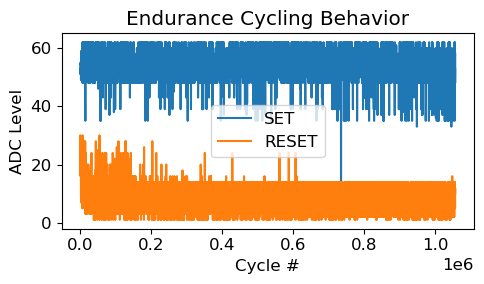

In [25]:
names = ["addr", "i", "Cycle #", "RESET", "SET"]
data = pd.read_csv(f"../data/endurance.csv.gz", delimiter='\t', names=names)
data = data[data["addr"] == 10900]
data = data[data["i"] == 9]
plt.rcParams["figure.figsize"] = (5,3)
data.groupby("i").plot("Cycle #", ["SET", "RESET"], title="Endurance Cycling Behavior", ylabel="ADC Level")
plt.tight_layout()
plt.savefig("figs/endurance.pdf")
plt.show()

In [44]:
# Get retention data
names = ["addr", "time", "lvl"]
data = pd.read_csv("../data/retention.csv.gz", delimiter='\t', names=names)
data["lvl"] = data["lvl"].str.strip('[]').str.split(', ')
data = data.explode("lvl", ignore_index=True)
data["lvl"] = pd.to_numeric(data["lvl"])
data["time"] -= data.groupby("addr")["time"].transform("first") 
data["lvli"] = data.groupby("addr")["lvl"].transform("first")
data["i"] = data.index % 16
data["tmin"] = data["addr"] % 60
data["tmax"] = data["addr"] % 60 + 4
data

,addr,time,lvl,lvli,i,tmin,tmax
0,13000,0.000000,41,41,0,40,44
1,13000,0.000000,41,41,1,40,44
2,13000,0.000000,35,41,2,40,44
3,13000,0.000000,37,41,3,40,44
4,13000,0.000000,37,41,4,40,44
...,...,...,...,...,...,...,...
16811051,13578,13895.539847,7,22,11,18,22
16811052,13578,13895.539847,28,22,12,18,22
16811053,13578,13895.539847,18,22,13,18,22
16811054,13578,13895.539847,7,22,14,18,22


In [45]:
# Get times
tdata = []
times = [0, 0.1, 1, 10, 100, 1000, 10000]
for time in times:
    idx = (data["time"] - time).abs().groupby([data["addr"], data["i"]]).idxmin()
    d = data[data.index.isin(idx)]
    # print(len(d))
    d = d[(d["time"] <= time*1.2) & (d["time"] >= time*0.8)]
    print(len(d))
    d["timept"] = time
    tdata.append(d)
tdata = pd.concat(tdata)
tdata


16384
16384
16384
3584
15792
16384
15280


,addr,time,lvl,lvli,i,tmin,tmax,timept
0,13000,0.000000,41,41,0,40,44,0.0
1,13000,0.000000,41,41,1,40,44,0.0
2,13000,0.000000,35,41,2,40,44,0.0
3,13000,0.000000,37,41,3,40,44,0.0
4,13000,0.000000,37,41,4,40,44,0.0
...,...,...,...,...,...,...,...,...
16800683,13954,8007.578099,23,34,11,34,38,10000.0
16800684,13954,8007.578099,36,34,12,34,38,10000.0
16800685,13954,8007.578099,19,34,13,34,38,10000.0
16800686,13954,8007.578099,36,34,14,34,38,10000.0


            2
-0.0001667 x + 0.01138 x + 4.01
            2
-0.0004366 x + 0.02686 x + 4.021
          2
-0.00083 x + 0.05323 x + 3.886
           2
-0.001104 x + 0.0664 x + 4.164
           2
-0.001803 x + 0.1068 x + 4.015
           2
-0.001837 x + 0.1071 x + 4.287
           2
-0.002014 x + 0.1214 x + 4.114


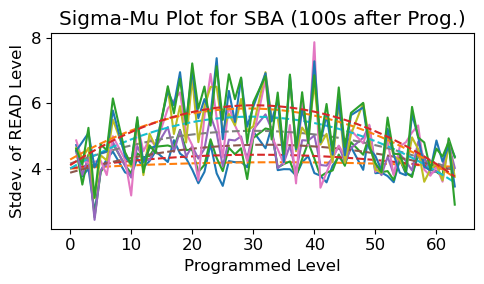

In [46]:
for time in [100]]:
    sbadata = tdata[(tdata["timept"] == time) & tdata["lvli"].isin(range(0,64,1))].groupby("lvli")["lvl"].std()
    sbadata.plot(label=f"data,t={time}")
    fit = np.polyfit(sbadata.index.values, sbadata.values, 2)
    print(np.poly1d(fit))
    plt.plot(range(64), np.poly1d(fit)(range(64)), '--', label=f"fit,t={time}")
plt.title("Sigma-Mu Plot for SBA (100s after Prog.)")
plt.xlabel("Programmed Level")
plt.ylabel("Stdev. of READ Level")
plt.legend()
plt.tight_layout()
plt.savefig("figs/sigmamu.pdf")
plt.show()